In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import os
import zipfile
import matplotlib.pyplot as plt
from google.colab import drive
import glob
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to denoise the image
def denoise_image(img):
    # Convert the image to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged_channels = cv2.merge([cl, a, b])

    # Convert the image back to RGB color space
    final_img = cv2.cvtColor(merged_channels, cv2.COLOR_Lab2RGB)
    return final_img

def filter_top_spots(mask, img, percentile=100):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    spots = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        spot_mask = np.zeros_like(mask)
        cv2.drawContours(spot_mask, [cnt], -1, 255, -1)
        spot = cv2.bitwise_and(img, img, mask=spot_mask)
        spots.append({
            'contour': cnt,
            'area': area,
        })

    # Sorting only by the area of the spots
    spots_sorted = sorted(spots, key=lambda x: x['area'], reverse=True)

    num_selected_spots = int(len(spots_sorted) * percentile / 100)
    selected_spots = spots_sorted[:num_selected_spots]

    filtered_mask = np.zeros_like(mask)
    for spot in selected_spots:
        cv2.drawContours(filtered_mask, [spot['contour']], -1, 255, -1)

    return filtered_mask




# Function to extract lighted spots and generate a mask while excluding edges using a circular mask
def circular_edge_exclusion_extract_lighted_spots_and_mask(img, contour_threshold, global_luminosity_threshold, ground_radius, edge_margin):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, global_luminosity_threshold, 255, cv2.THRESH_BINARY)
    cv2.circle(thresh, (thresh.shape[1]//2, thresh.shape[0]//2), ground_radius, 0, -1)
    mask = np.zeros_like(thresh)
    cv2.circle(mask, (mask.shape[1]//2, mask.shape[0]//2), mask.shape[0]//2 - edge_margin, 255, -1)
    thresh = cv2.bitwise_and(thresh, mask)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(thresh)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > contour_threshold:
            cv2.drawContours(mask, [cnt], -1, 255, -1)
    refined_mask = cv2.dilate(mask, np.ones((3,3), np.uint8), iterations=2)
    return mask, refined_mask



def extract_metrics_from_mask(img, mask, image_centroid):
    # Total Area
    total_area = np.count_nonzero(mask)

    # Extract the region of interest from the original image using the mask
    roi = cv2.bitwise_and(img, img, mask=mask)
    roi_luminosity = 0.299 * roi[:,:,0] + 0.587 * roi[:,:,1] + 0.114 * roi[:,:,2]

    # Area-weighted spot-level average luminosity
    total_luminosity = np.sum(roi_luminosity)
    avg_luminosity = total_luminosity / total_area

    # Standard deviation of area-weighted spot-level luminosity
    lum_deviation = roi_luminosity - avg_luminosity
    weighted_lum_std = np.sqrt(np.sum(lum_deviation**2) / total_area)

    # Calculate the coordinates of non-zero pixels in the mask
    non_zero_coords = np.array(np.nonzero(mask)).T

    # Distances from each spot's centroid to image centroid
    distances = np.linalg.norm(non_zero_coords - np.array(image_centroid), axis=1)

    # Area-weighted average distance from each centroid to the image centroid
    avg_distance = np.mean(distances)
    mid_distance = np.median(distances)

    # Standard deviation of area-weighted distances
    distance_deviation = distances - avg_distance
    weighted_dist_std = np.sqrt(np.sum(distance_deviation**2) / total_area)

    # Extracting maximum contour size and its enclosing circle area
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        max_contour_size = cv2.contourArea(max_contour)
    else:
        max_contour_size = 0

    # Return all features
    return [total_area, total_luminosity, avg_luminosity, avg_distance, mid_distance, weighted_lum_std, weighted_dist_std, max_contour_size]





In [ ]:
# Extract the images from the zip file
#zip_path = "/content/drive/MyDrive/1215_update/SVI_data/1216_day_night_paired_complete_2831_fisheye.zip"
#extract_folder = "/content/drive/MyDrive/1215_update/SVI_data/1216_day_night_paired_complete_2831_fisheye"
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_folder)

folder_path = "/content/drive/MyDrive/1215_update/SVI_data/1216_day_night_paired_complete_2831_fisheye"
patterns = ["*.jpg"]

# Extract all image paths based on patterns
image_paths = []
for pattern in patterns:
    image_paths.extend(glob.glob(f"{folder_path}/{pattern}", recursive=True))



all_loaded_images = [cv2.imread(img_name)[..., ::-1] for img_name in image_paths]



In [ ]:
import pandas as pd
import os

# Extract image file names from the paths
img_names = [os.path.basename(img_path).split('fisheye_compressed_')[1].split('.jpg')[0] for img_path in image_paths]

# Create a DataFrame with the image names
df_img_names = pd.DataFrame(img_names, columns=['day_svi_id'])

# Display the DataFrame
print(df_img_names)


                  day_svi_id
0     eKql4ti0fxvT41Zzd26LTg
1     eMGVMBSna6yvKKOGsnV_Qw
2     eLPgjhILzF1wotouw-xfPA
3     eLk9Xu3J40y-39xpvXiWvg
4     eMDu-VdtB0ydbA0iHPDORQ
...                      ...
2826  IALT5XYV6GBeXRq5xGz85g
2827  IA2bNOksOvQ5J4ui-M0ZUQ
2828  ICf8n7q388FtadH2kebU9A
2829  IAfHrSkWnORfq6oeNyr4aw
2830  IFDVisVBMaGeJOtkLpvuuw

[2831 rows x 1 columns]


In [ ]:
#new_image_paths = ['/content/drive/MyDrive/2023_Spring_ISM/0821_CNN_Lumi/day_night_all_fisheye/fisheye_' +i + '.jpg' for i in predictions_and_errors['pano_id']]
#all_loaded_images = [cv2.imread(img_name)[..., ::-1] for img_name in new_image_paths]

In [ ]:
# Apply extraction and denoise functions to all loaded images
all_contoured_images = []
all_mask_images = []
all_feature_vectors = []

for img in all_loaded_images:
    filtered_img = denoise_image(img)
    contoured_img, mask_img = circular_edge_exclusion_extract_lighted_spots_and_mask(filtered_img, 50, 130, int(0.45 * filtered_img.shape[0] // 2), 50)
    all_contoured_images.append(contoured_img)
    all_mask_images.append(mask_img)

    # Extract feature vectors within the loop
    image_centroid = (img.shape[0] // 2, img.shape[1] // 2)
    feature_vector = extract_metrics_from_mask(img, mask_img, image_centroid)
    all_feature_vectors.append(feature_vector)

# Convert to numpy array for clustering
all_feature_vectors_all = np.array(all_feature_vectors)


In [ ]:
# Ensure all_feature_vectors_all is a numpy array
all_feature_vectors_all = np.array(all_feature_vectors)

# Convert the numpy array of feature vectors into a DataFrame
df_feature_vectors = pd.DataFrame(all_feature_vectors_all)
df_feature_vectors.columns = ['total_area', 'total_luminosity', 'avg_luminosity', 'avg_distance', 'mid_distance', 'weighted_lum_std', 'weighted_dist_std', 'max_contour_size']
info_csv_path = '/content/drive/MyDrive/1215_update/SVI_data/1216_complete.csv'



In [ ]:
#predictions_and_errors_csv_path = '/content/drive/MyDrive/1215_update/SVI_data/1225_info_with_predictions_and_errors_pca.csv'
#predictions_and_errors = pd.read_csv(predictions_and_errors_csv_path).drop_duplicates('pano_id')
#predictions_and_errors = predictions_and_errors.loc[predictions_and_errors.abs_error<16.2]
#predictions_and_errors.columns

In [ ]:
info_csv = pd.read_csv(info_csv_path)

info_csv = df_img_names.merge(info_csv, on = 'day_svi_id')

info_csv = pd.concat([info_csv.reset_index(drop=True), df_feature_vectors.reset_index(drop=True)], axis=1)

info_csv

day_svi_id  Unnamed: 0.1  Unnamed: 0             svi_name  \
0     eKql4ti0fxvT41Zzd26LTg           850         850  GS013057_000958.jpg   
1     eMGVMBSna6yvKKOGsnV_Qw            65          73  GS012706_002700.jpg   
2     eLPgjhILzF1wotouw-xfPA          1376        1747    GS012730_0316.jpg   
3     eLk9Xu3J40y-39xpvXiWvg          1294        1640    GS012729_1058.jpg   
4     eMDu-VdtB0ydbA0iHPDORQ           851         851  GS013054_000584.jpg   
...                      ...           ...         ...                  ...   
2826  IALT5XYV6GBeXRq5xGz85g           708         859    GS012727_0806.jpg   
2827  IA2bNOksOvQ5J4ui-M0ZUQ           371         371  GS013058_001094.jpg   
2828  ICf8n7q388FtadH2kebU9A           507         601    GS012726_0306.jpg   
2829  IAfHrSkWnORfq6oeNyr4aw          1140        1434    GS012729_0286.jpg   
2830  IFDVisVBMaGeJOtkLpvuuw           932        1163    GS012728_0296.jpg   

      year  month  day_svi_lat  day_svi_lon  day_svi_heading  \
0     2018      2     1.322684   103.800986         2.219791   
1     2019      7     1.278909   103.843885         6.244040   
2     2016      9     1.298061   103.767196         3.142920   
3     2021      7     1.309294   103.766502         3.664048   
4     2018      3     1.322004   103.655930         2.319903   
...    ...    ...          ...          ...              ...   
2826  2016      8     1.284281   103.787379         2.709981   
2827  2018      2     1.327131   103.793494         0.357814   
2828  2022      5     1.288734   103.778136         2.334028   
2829  2021      3     1.305698   103.771108         0.020700   
2830  2022      7     1.296967   103.782193         0.462038   

      GPS (Lat.) [deg]  ...  selected  version  total_area  total_luminosity  \
0             1.322666  ...         1        2     14857.0       1381625.420   
1             1.278920  ...         1        1     58467.0       6801355.031   
2             1.298041  ...         1        1     21882.0       2635313.409   
3             1.309295  ...         1        1     30418.0       3308106.108   
4             1.322029  ...         1        2     28813.0       3320834.954   
...                ...  ...       ...      ...         ...               ...   
2826          1.284278  ...         1        1      9098.0       1098626.743   
2827          1.327094  ...         1        2     29498.0       3429198.370   
2828          1.288765  ...         1        1     44457.0       5481261.222   
2829          1.305688  ...         1        1     19630.0       2037475.118   
2830          1.296953  ...         1        1     39302.0       5053383.846   

      avg_luminosity  avg_distance  mid_distance  weighted_lum_std  \
0          92.994913    179.715270    176.139150        489.198773   
1         116.328100    194.488517    191.671594        295.045577   
2         120.432932    197.344977    188.614686        518.755387   
3         108.754886    172.764313    164.015243        393.780897   
4         115.254745    187.974831    179.136819        429.736594   
...              ...           ...           ...               ...   
2826      120.754753    224.973686    235.917358        816.526726   
2827      116.251894    195.893777    195.849432        429.233554   
2828      123.293547    199.548642    190.234066        363.533176   
2829      103.793944    182.155275    172.930622        474.016212   
2830      128.578287    176.650144    171.723615        405.978514   

      weighted_dist_std  max_contour_size  
0             24.862766            2859.0  
1             29.330467           21764.0  
2             43.147476            9321.5  
3             24.004036           11848.5  
4             30.723370           13473.5  
...                 ...               ...  
2826          35.215493            6693.0  
2827          34.208155           16472.5  
2828          43.774546           21615.0  
2829          31.215153            4640.0  
2830          

In [ ]:
info_csv[['lux','total_area','avg_distance']].values

array([[8.00000000e+00, 1.48570000e+04, 1.79715270e+02],
       [3.50000000e+01, 5.84670000e+04, 1.94488517e+02],
       [2.70000000e+01, 2.18820000e+04, 1.97344977e+02],
       ...,
       [4.10000000e+01, 4.44570000e+04, 1.99548642e+02],
       [1.20000000e+01, 1.96300000e+04, 1.82155275e+02],
       [7.00000000e+00, 3.93020000e+04, 1.76650144e+02]])

In [ ]:
# [total_area, total_luminosity, avg_luminosity, avg_distance, mid_distance, weighted_lum_std, weighted_dist_std, max_contour_size]
all_feature_vectors= all_feature_vectors_all[:, [7, 2, 3]]
all_feature_vectors= all_feature_vectors_all[:, [0, 1, 3]]
all_feature_vectors = info_csv[['total_area','lux','avg_distance']].values
#all_feature_vectors= all_feature_vectors_all

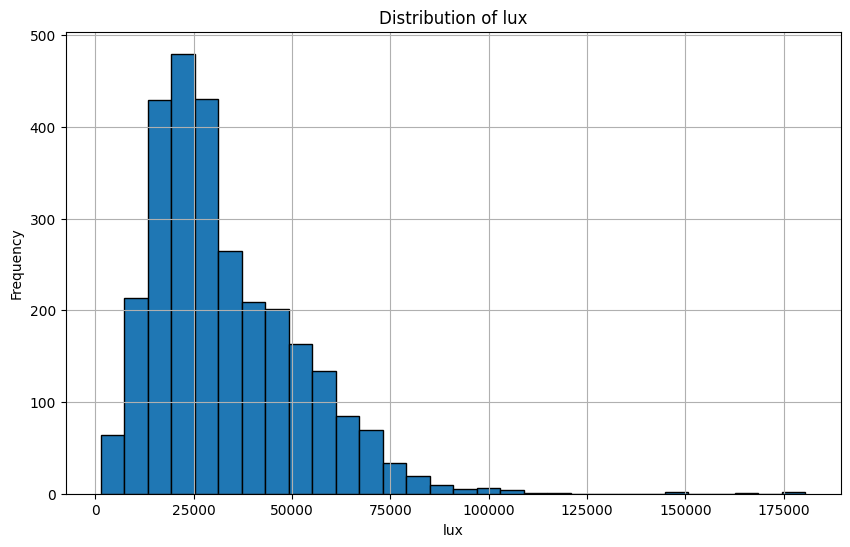

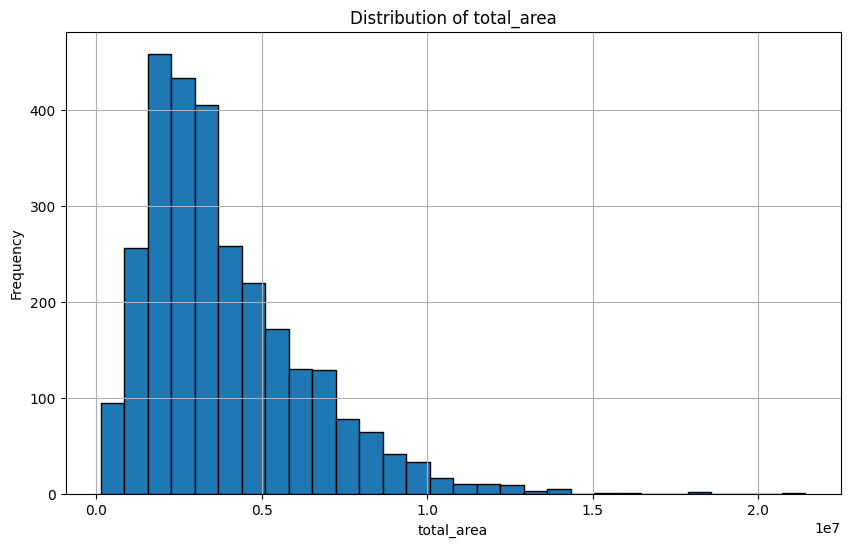

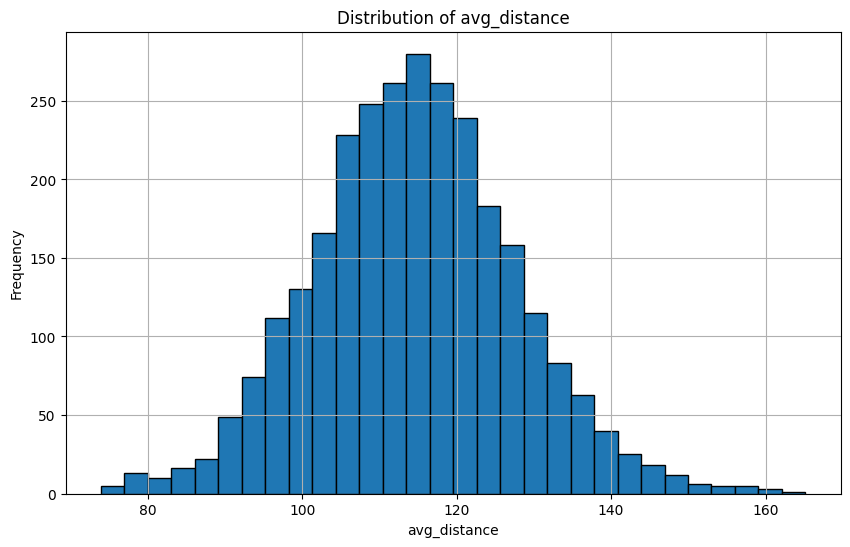

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the distribution of three features
#features = ['total_area', 'avg_luminosity', 'weighted_lum_std', 'avg_distance', 'weighted_dist_std']
#features = ['total_area', 'avg_luminosity', 'avg_distance']
#features = ['total_area', 'total_luminosity','avg_distance']
features = ['lux','total_area','avg_distance']

for i, feature in enumerate(features):
    plt.figure(figsize=(10, 6))
    plt.hist( all_feature_vectors_all[:, i], bins=30, edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()



In [ ]:
# Remove potential outliers using IQR method
Q1 = np.percentile(all_feature_vectors, 25, axis=0)
Q3 = np.percentile(all_feature_vectors, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Get boolean array indicating the presence of outliers for each feature
outliers = (all_feature_vectors < lower_bound) | (all_feature_vectors > upper_bound)

# Remove rows (samples) that have outliers for any feature
non_outliers_indices = ~outliers.any(axis=1)
all_feature_vectors_cleaned = all_feature_vectors[non_outliers_indices]

# Now, apply scaling again to the cleaned data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()
#scaler = MinMaxScaler()
all_feature_vectors_cleaned = scaler.fit_transform(all_feature_vectors_cleaned)
points = all_feature_vectors_cleaned
len(all_feature_vectors_cleaned )

2670

In [ ]:
#all_feature_vectors_cleaned = all_feature_vectors
# Now, apply scaling again to the cleaned data
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#all_feature_vectors_cleaned = scaler.fit_transform(all_feature_vectors_cleaned)
#points = all_feature_vectors_cleaned
#len(all_feature_vectors_cleaned)

2831

In [ ]:
all_feature_vectors_cleaned

array([[-0.95863341, -0.55590952, -0.89799725],
       [ 1.35632535,  1.04932095,  0.20285034],
       [-0.58572386,  0.57369711,  0.41570311],
       ...,
       [ 0.61262959,  1.40603884,  0.57991208],
       [-0.70526725, -0.3180976 , -0.71617711],
       [ 0.33898564, -0.6153625 , -1.12639904]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

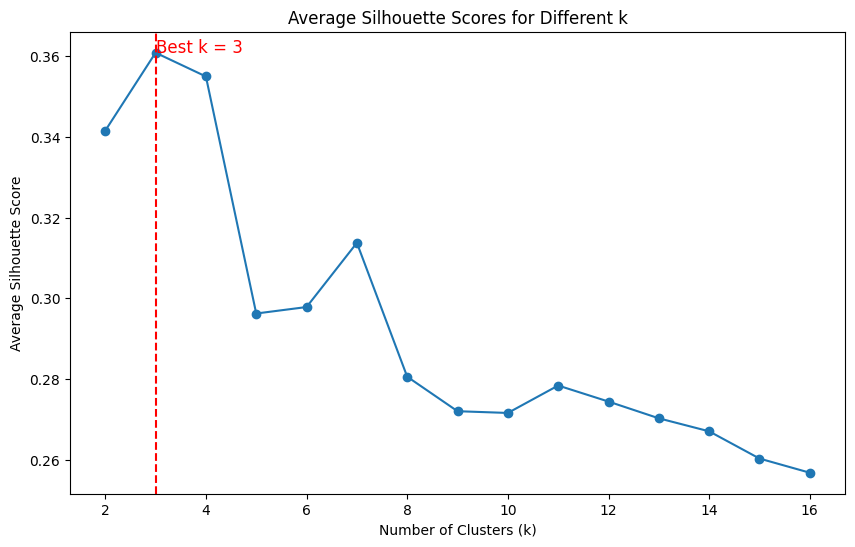

3

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming 'x' is your dataset
# Example data
np.random.seed(0)
x = all_feature_vectors_cleaned

kmax = 16
iterations = 50  # Number of times to run silhouette analysis for each k

# Function to calculate average silhouette scores for each k
def calculate_average_silhouette_scores(points, kmax, iterations):
    average_sil_scores = []
    for k in range(2, kmax+1):
        sil_scores = []
        for _ in range(iterations):
            kmeans = KMeans(n_clusters=k).fit(points)
            labels = kmeans.labels_
            sil_scores.append(silhouette_score(points, labels, metric='euclidean'))
        average_sil_scores.append(np.mean(sil_scores))
    return average_sil_scores

# Calculate average silhouette scores
average_sil_scores = calculate_average_silhouette_scores(x, kmax, iterations)

# Find the k with the highest average silhouette score
best_k = np.argmax(average_sil_scores) + 2  # +2 because range starts from 2



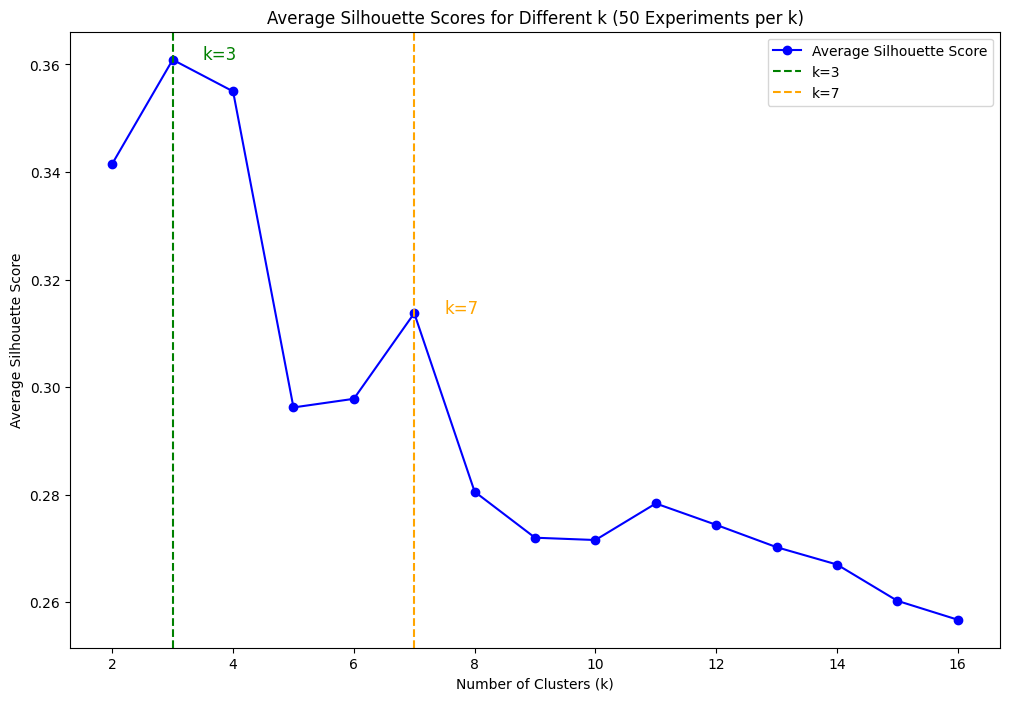

In [ ]:

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(range(2, kmax+1), average_sil_scores, marker='o', color='blue', label='Average Silhouette Score')

# Highlight k=3 and k=7 with vertical lines
plt.axvline(x=3, color="green", linestyle="--", label='k=3')
plt.axvline(x=7, color="orange", linestyle="--", label='k=7')

# Highlight the best k with a vertical line
#plt.axvline(x=best_k, color="red", linestyle="--", label=f'Best k = {best_k}')

# Annotate k=3, k=7, and best k
plt.text(3.5, average_sil_scores[1], f'k=3', color="green", fontsize=12, ha='left')
plt.text(7.5, average_sil_scores[5], f'k=7', color="orange", fontsize=12, ha='left')
#plt.text(best_k, max(average_sil_scores), f'Best k = {best_k}', color = "red", fontsize=12, ha='center')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Scores for Different k (50 Experiments per k)')
plt.legend()

# Add a note explaining the selection of k=7
#plt.figtext(0.5, 0.01, 'Though k=3 has the highest silhouette score, we choose k=7 for better diversity', ha="center", fontsize=12, color='black')

plt.show()

# Output the chosen k value
#best_k

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

NameError: name 'Line2D' is not defined

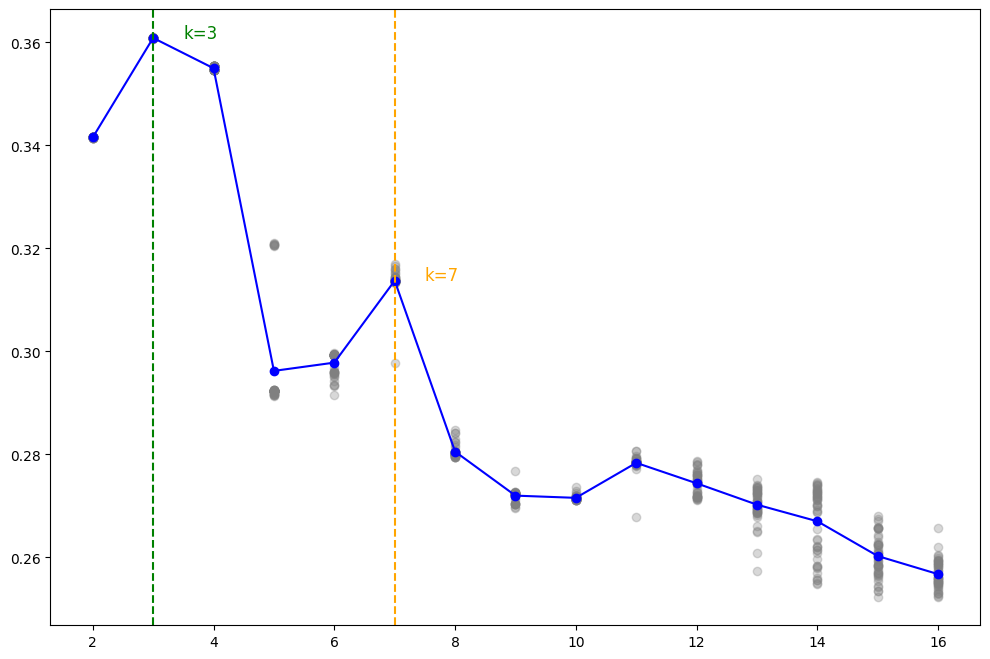

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming 'x' is your dataset
# Example data
np.random.seed(0)
x = all_feature_vectors_cleaned

kmax = 16
iterations = 50  # Number of times to run silhouette analysis for each k

# Function to calculate average silhouette scores for each k
def calculate_average_silhouette_scores(points, kmax, iterations):
    all_sil_scores = {}  # Dictionary to hold all silhouette scores for each k
    average_sil_scores = []

    for k in range(2, kmax+1):
        sil_scores = []
        for _ in range(iterations):
            kmeans = KMeans(n_clusters=k).fit(points)
            labels = kmeans.labels_
            score = silhouette_score(points, labels, metric='euclidean')
            sil_scores.append(score)

        all_sil_scores[k] = sil_scores
        average_sil_scores.append(np.mean(sil_scores))

    return average_sil_scores, all_sil_scores

# Calculate average silhouette scores and store all individual scores
average_sil_scores, all_sil_scores = calculate_average_silhouette_scores(x, kmax, iterations)

# Find the k with the highest average silhouette score
best_k = np.argmax(average_sil_scores) + 2  # +2 because range starts from 2



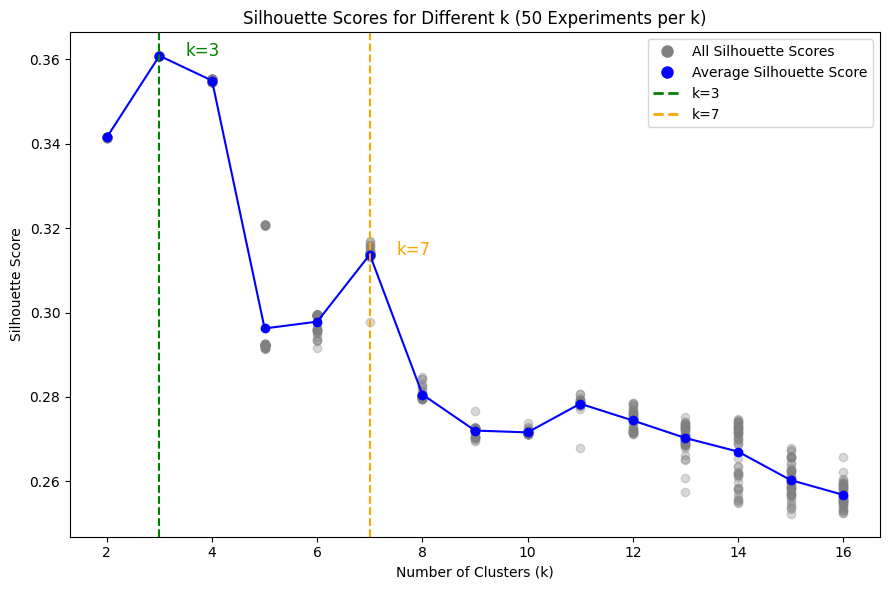

In [ ]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

# Plot all individual silhouette scores with alpha
for k in range(2, kmax+1):
    plt.plot([k] * iterations, all_sil_scores[k], 'o', color='gray', alpha=0.3)

# Plot the average silhouette scores
plt.plot(range(2, kmax+1), average_sil_scores, marker='o', color='blue', label='Average Silhouette Score')

# Highlight k=3 and k=7 with vertical lines
plt.axvline(x=3, color="green", linestyle="--", label='k=3')
plt.axvline(x=7, color="orange", linestyle="--", label='k=7')

# Annotate k=3 and k=7
plt.text(3.5, average_sil_scores[1], f'k=3', color="green", fontsize=12, ha='left')
plt.text(7.5, average_sil_scores[5], f'k=7', color="orange", fontsize=12, ha='left')

# Create a custom legend for the gray dots
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='All Silhouette Scores'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Average Silhouette Score'),
                   Line2D([0], [0], color='green', lw=2, linestyle="--", label='k=3'),
                   Line2D([0], [0], color='orange', lw=2, linestyle="--", label='k=7')]

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k (50 Experiments per k)')

# Add the legend
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.savefig('silhourtte_k_50.png', dpi=300)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming 'all_feature_vectors_cleaned' is your dataset
# Example: x = np.random.rand(100, 2)  # Replace with all_feature_vectors_cleaned
x = all_feature_vectors_cleaned

# Set the number of clusters
n_clusters = 7

# Set a fixed random seed for reproducibility
np.random.seed(238)

# Apply KMeans clustering with the fixed random seed
kmeans_all = KMeans(n_clusters=n_clusters).fit(x)

# Retrieve the cluster assignments for each data point
all_cluster_assignments = kmeans_all.labels_
centroids = kmeans_all.cluster_centers_
# all_cluster_assignments now contains the cluster assignments


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


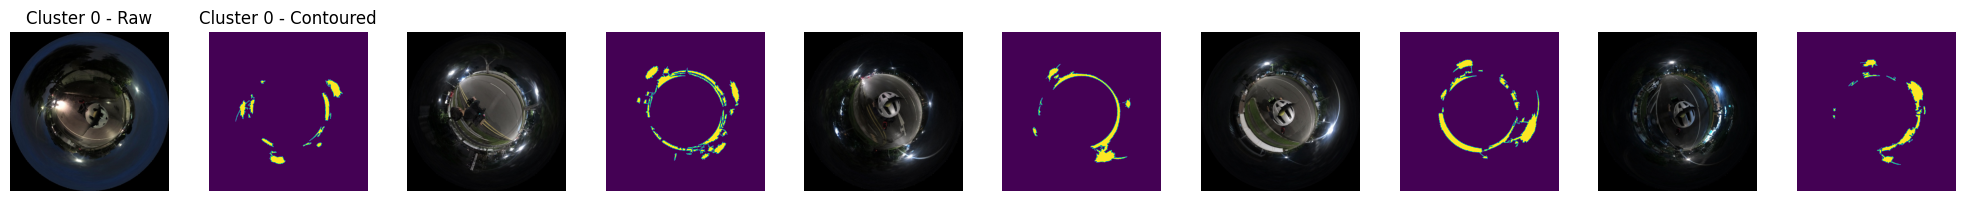

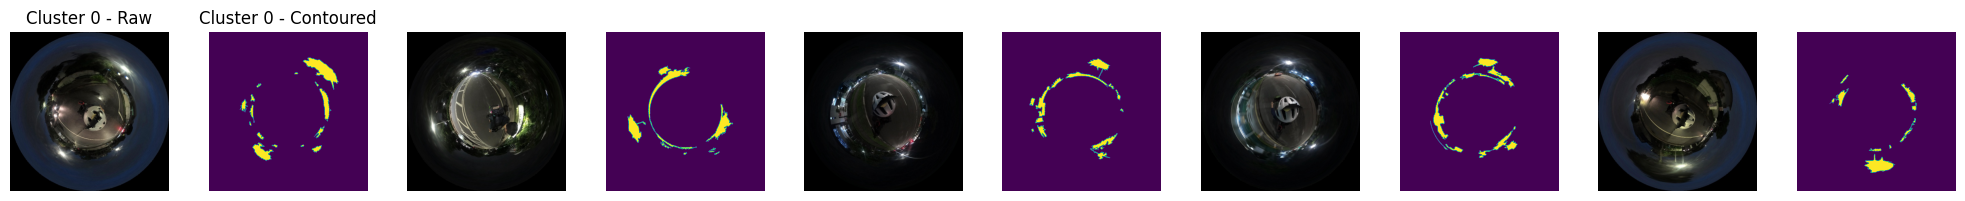

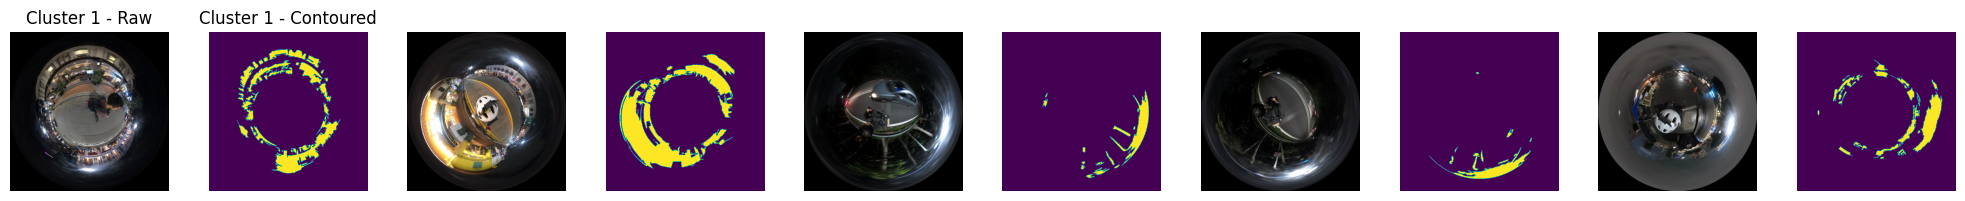

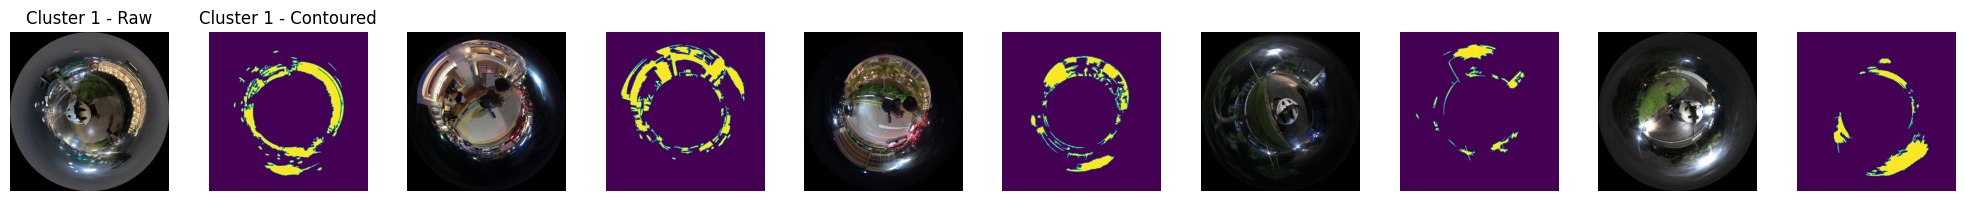

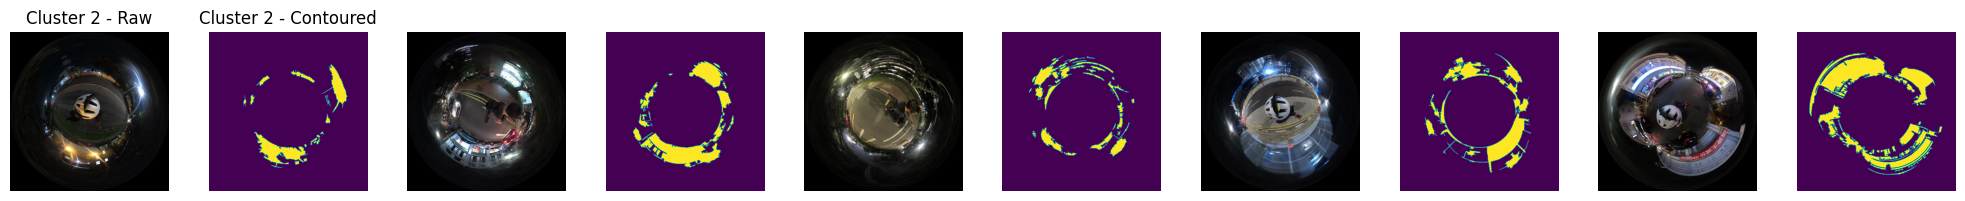

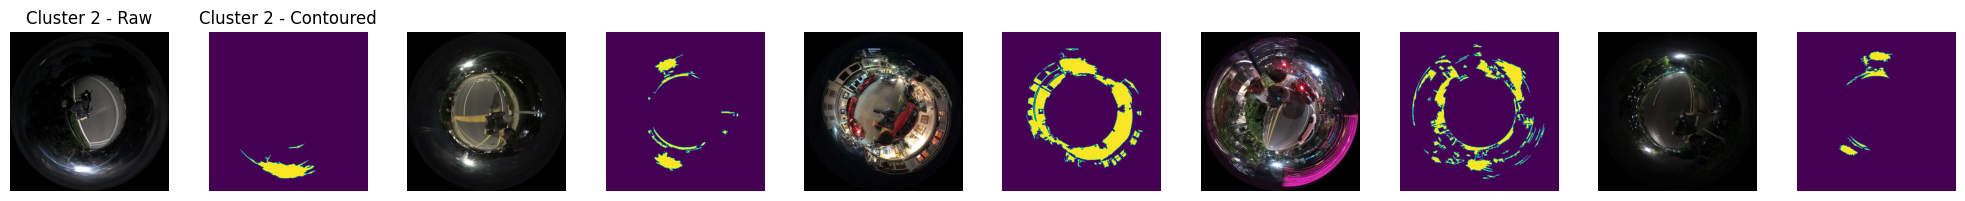

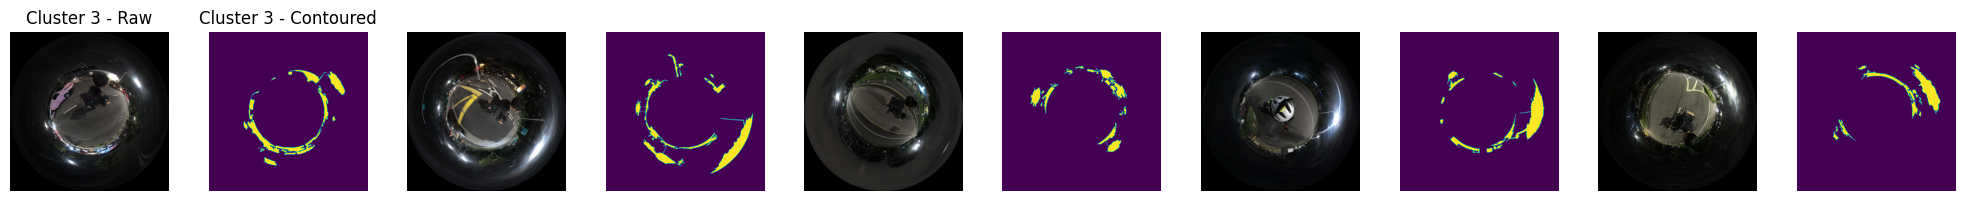

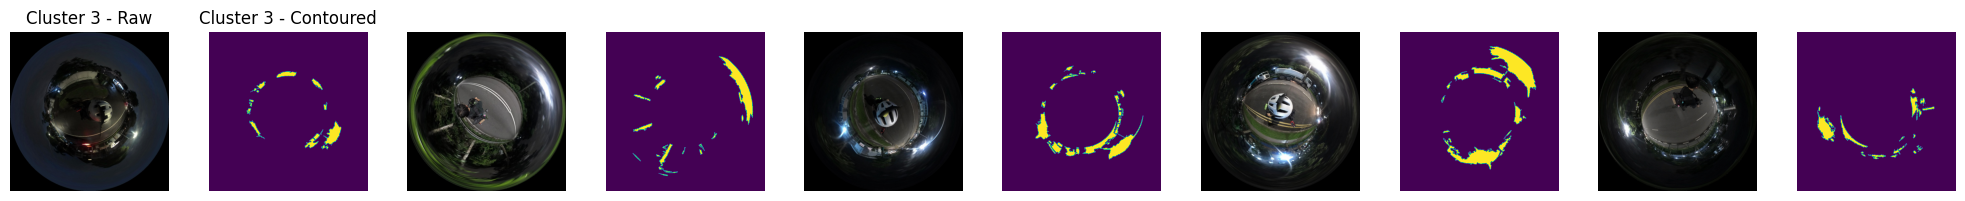

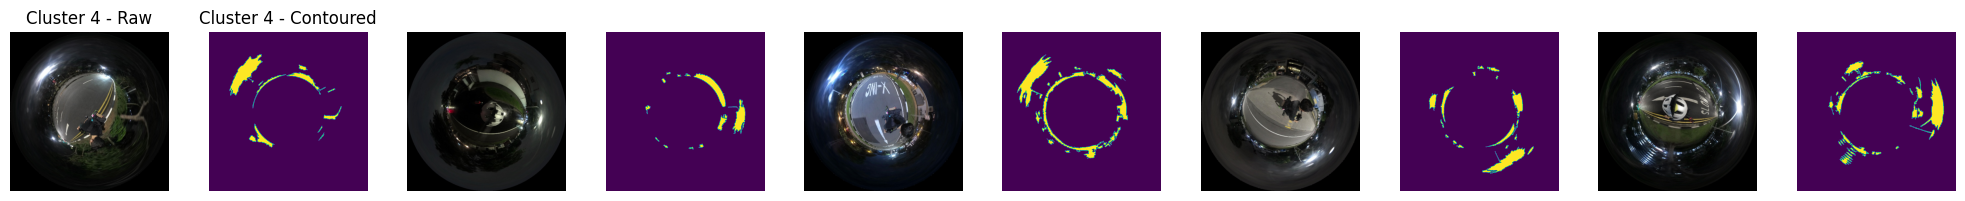

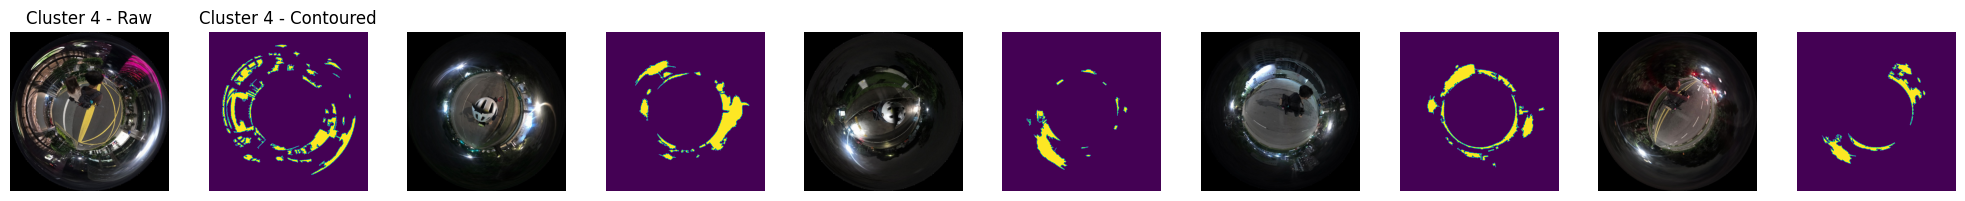

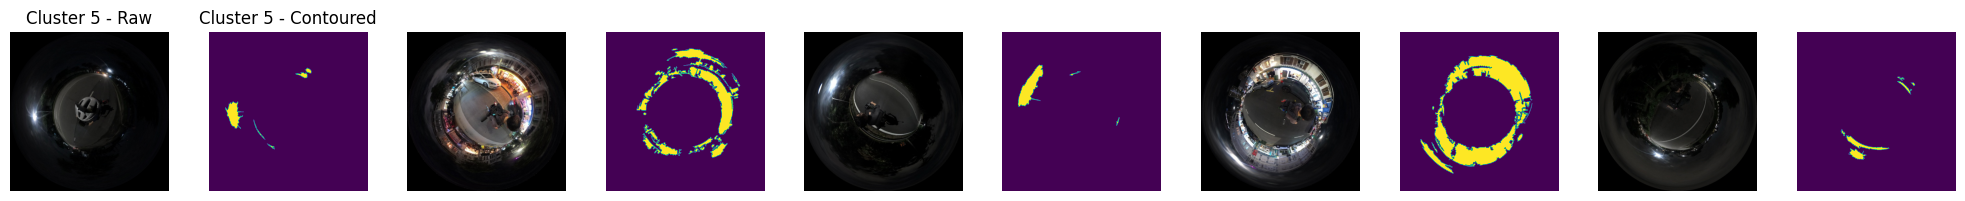

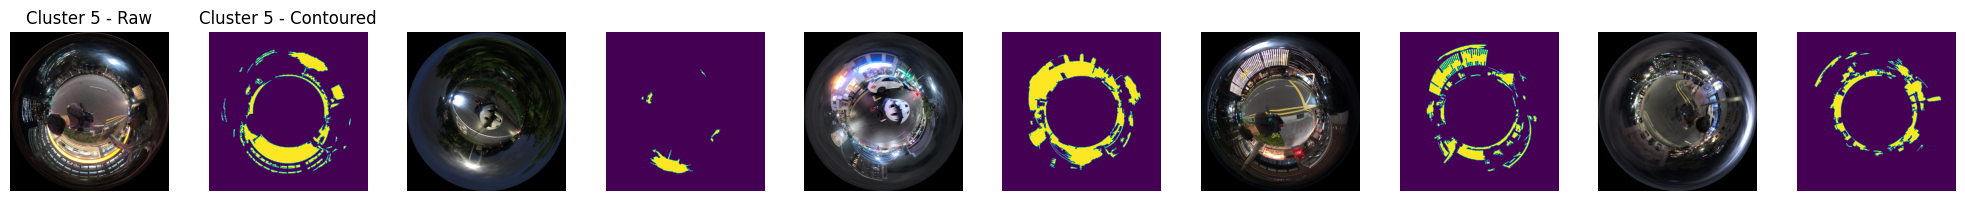

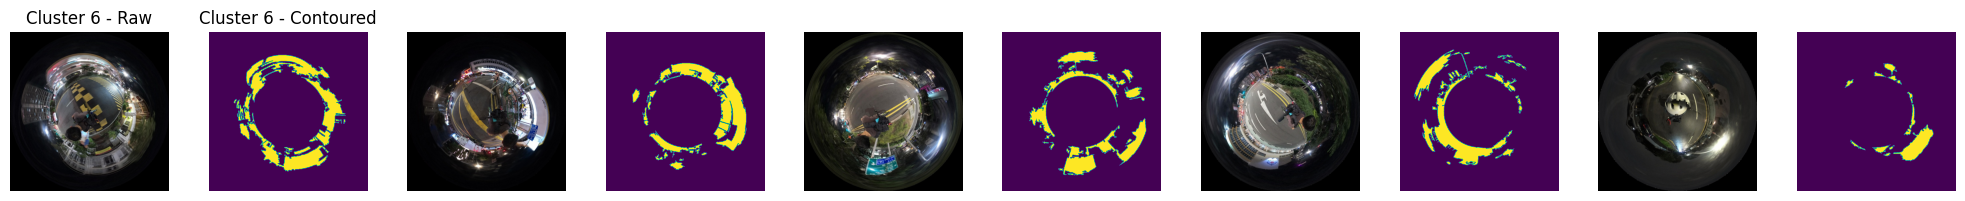

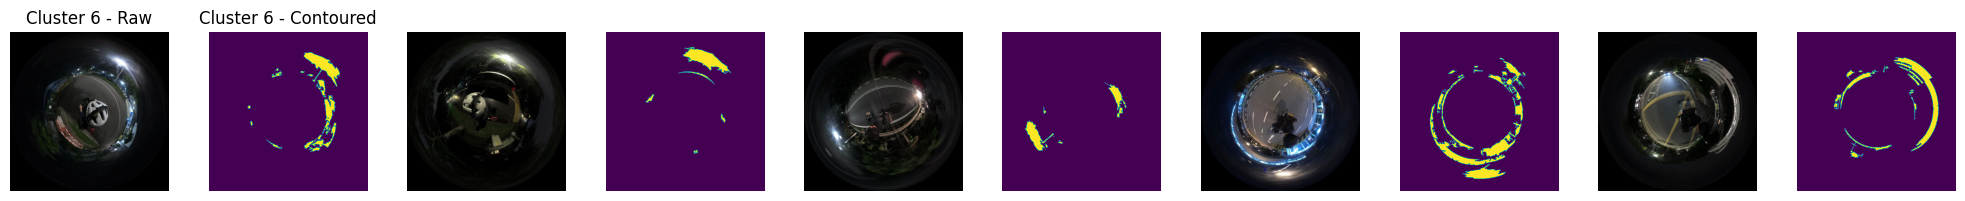

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_images_by_cluster(raw_images, contoured_images, cluster_assignments, images_per_row=5):
    assert len(raw_images) == len(contoured_images), "Raw and contoured images lists should have the same length"

    unique_clusters = np.unique(cluster_assignments)

    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_assignments == cluster)[0]
        #total_images = len(cluster_indices)
        total_images = 10
        # Calculate number of rows required for the given images_per_row (since we're showing 2 images side-by-side for each original image)
        total_rows = -(-total_images // images_per_row)

        for row in range(total_rows):
            fig, axes = plt.subplots(1, images_per_row * 2, figsize=(20, 2))  # times 2 because of raw and contoured images

            start_idx = row * images_per_row
            end_idx = start_idx + images_per_row
            row_indices = cluster_indices[start_idx:end_idx]

            for i, idx in enumerate(row_indices):
                # Raw image
                axes[2*i].imshow(raw_images[idx])
                axes[2*i].axis('off')

                # Contoured image
                axes[2*i + 1].imshow(contoured_images[idx])
                axes[2*i + 1].axis('off')

                # Put cluster label for the first pair in the row
                if i == 0:
                    axes[2*i].set_title(f'Cluster {cluster} - Raw')
                    axes[2*i + 1].set_title(f'Cluster {cluster} - Contoured')

            # Turn off any remaining axes
            for j in range(2 * len(row_indices), 2 * images_per_row):
                axes[j].axis('off')

            plt.tight_layout()
            plt.show()

# Usage
# Assuming `all_loaded_images` are your raw images
display_images_by_cluster(all_loaded_images, all_contoured_images, all_cluster_assignments)


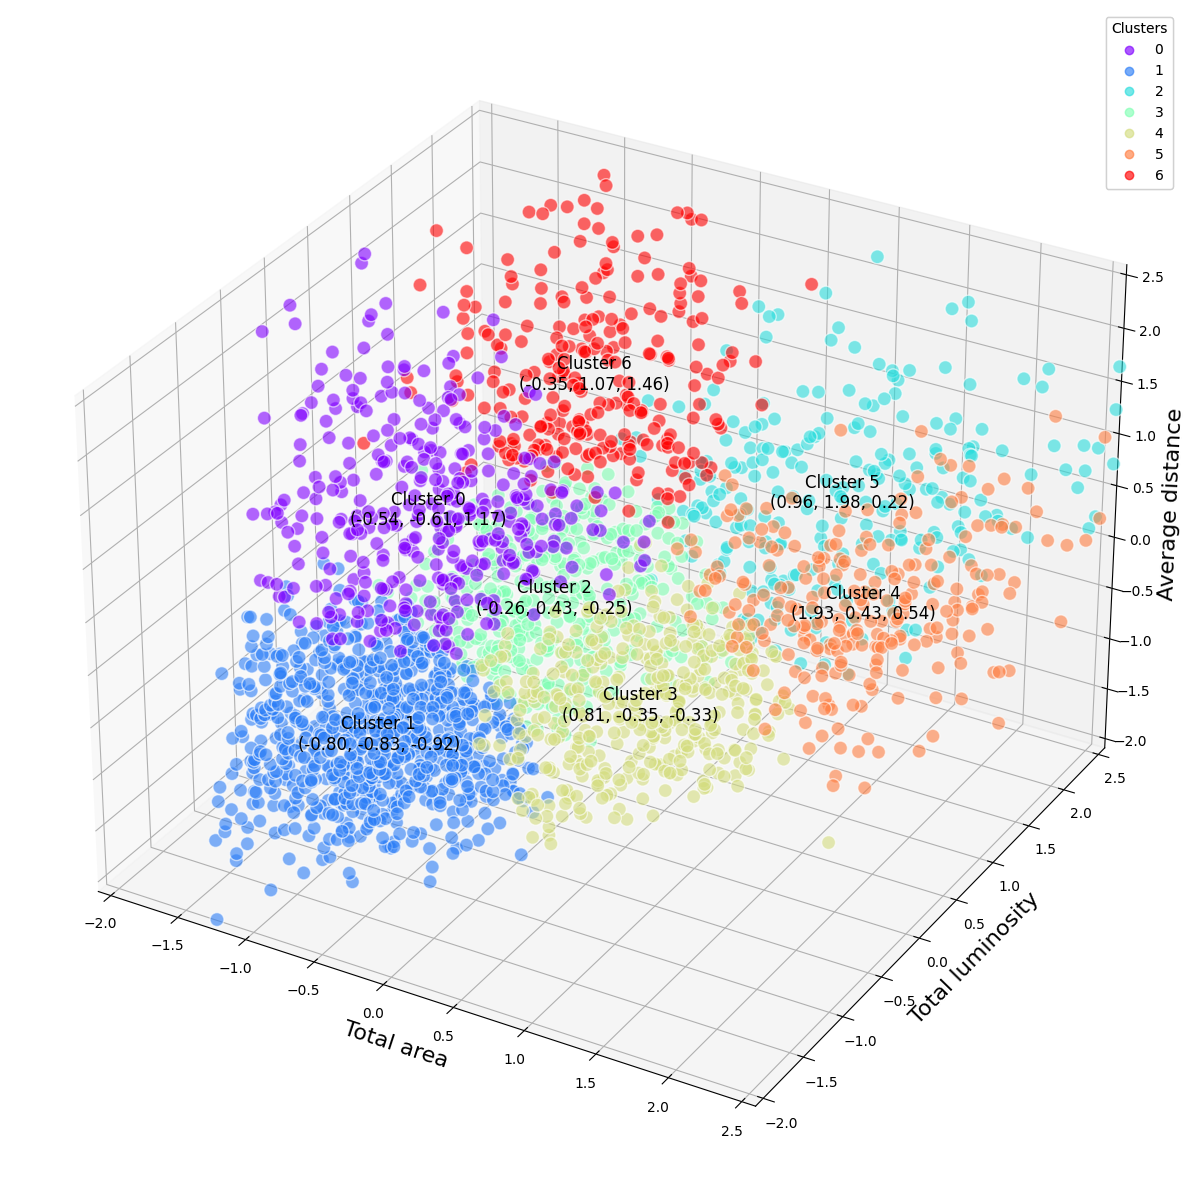

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Swap cluster labels: Cluster 2 to 4, 3 to 2, and 4 to 3
new_cluster_assignments = all_cluster_assignments.copy()

# First, handle the swaps in a way that avoids overwriting before all swaps are completed
# Use a temporary label for intermediate swapping
temp_label = max(all_cluster_assignments) + 1

new_cluster_assignments[all_cluster_assignments == 2] = temp_label  # Temporarily assign to a new label
new_cluster_assignments[all_cluster_assignments == 3] = 2
new_cluster_assignments[all_cluster_assignments == 4] = 0
new_cluster_assignments[new_cluster_assignments == temp_label] = 5

# Correctly assign other clusters
new_cluster_assignments[all_cluster_assignments == 1] = 6
new_cluster_assignments[all_cluster_assignments == 6] = 3
new_cluster_assignments[all_cluster_assignments == 5] = 4
new_cluster_assignments[all_cluster_assignments == 0] = 1

# Swap colors/labels for clusters 3 and 5
temp_assignments = new_cluster_assignments.copy()
new_cluster_assignments[temp_assignments == 3] = 5
new_cluster_assignments[temp_assignments == 5] = 3

# Adjust centroids if necessary
centroids = kmeans_all.cluster_centers_

# Correct label mapping (after swapping 3 and 5)
label_mapping = {3: 5, 5: 3, 2: 2, 1: 6, 0: 1, 4: 0, 6: 4}

# Plotting
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x[:, 0], x[:, 1], x[:, 2],
                     c=new_cluster_assignments, cmap='rainbow', alpha=0.6, edgecolors='w', s=100)

# Annotate each cluster centroid with the correct new labels
for idx, center in enumerate(centroids):
    if idx in label_mapping:
        new_label = label_mapping[idx]
    else:
        new_label = idx
    ax.text(center[0], center[1], center[2],
            s=f'Cluster {new_label}\n({center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f})',
            color='black', fontsize=12, ha='center', va='center')

# Add legend and set titles, labels, and limits
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
#ax.set_title("3D Scatter Plot of Clustering Results with Corrected Labels", fontsize=20)
ax.set_xlabel("Total area", fontsize=16)
ax.set_ylabel("Total luminosity", fontsize=16)
ax.set_zlabel("Average distance", fontsize=16)
ax.set_xlim(-2, 2.5)
ax.set_ylim(-2, 2.5)
ax.set_zlim(-2, 2.5)
plt.tight_layout()
plt.savefig('3D_visualizations_clustering.png', dpi=300)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

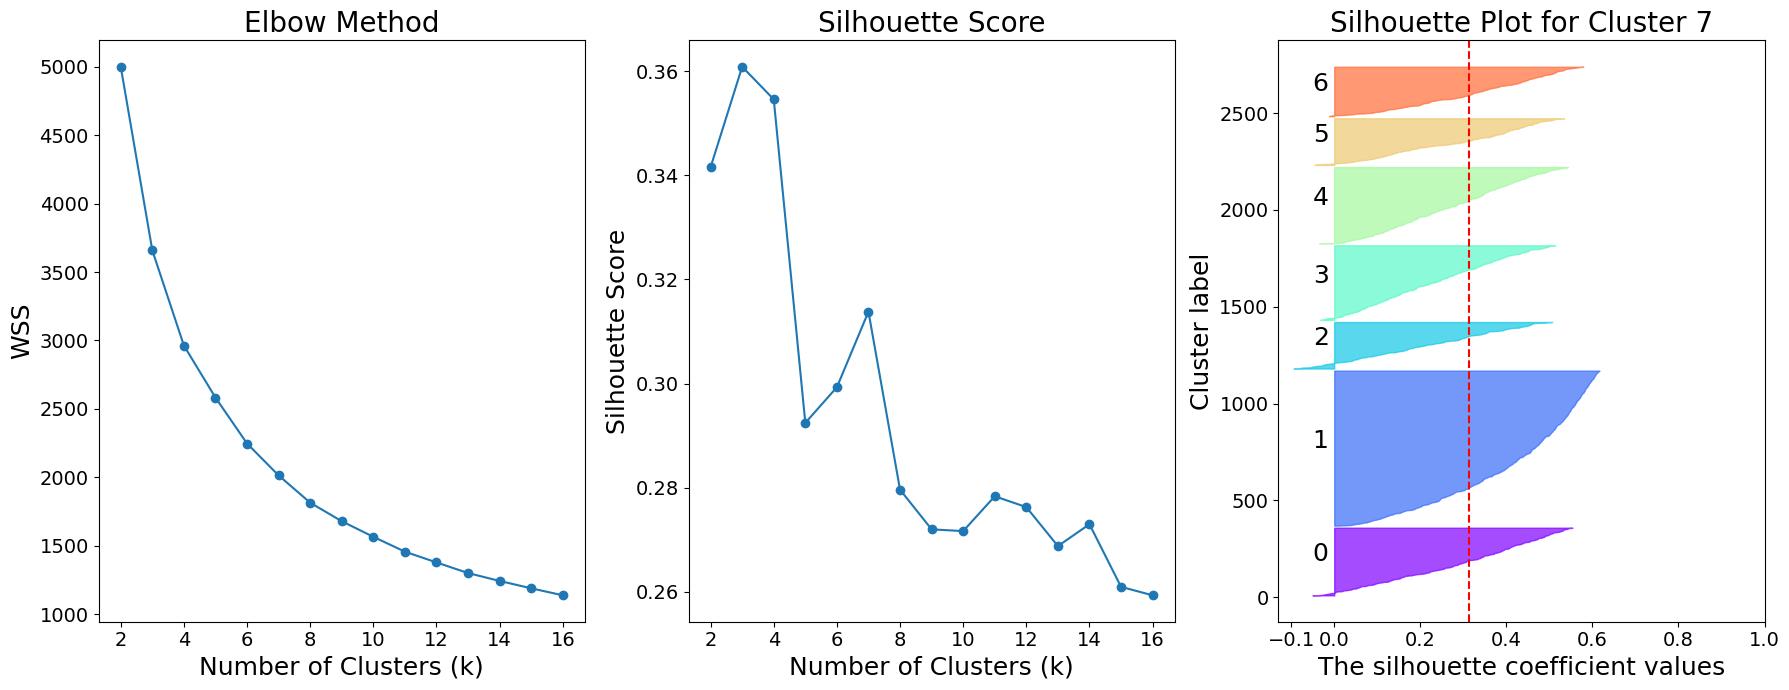

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.cm import rainbow

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Your data points 'x' and maximum number of clusters 'kmax'
kmax = 16

# Calculate WSS (Elbow method)
def calculate_WSS(points, kmax):
    sse = []
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters=k).fit(points)
        sse.append(kmeans.inertia_)
    return sse

# Calculate Silhouette Scores
sil_scores = []
for k in range(2, kmax+1):
    np.random.seed(238)
    kmeans = KMeans(n_clusters=k).fit(x)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(x, labels, metric='euclidean'))


sse = calculate_WSS(x, kmax)
# Recalculate silhouette scores using the updated cluster labels
new_silhouette_avg = silhouette_score(x, new_cluster_assignments)
new_sample_silhouette_values = silhouette_samples(x, new_cluster_assignments)
cmap = cm.get_cmap('rainbow')
# Redraw the silhouette plot with the updated cluster labels
fig, axs = plt.subplots(1, 3, figsize=(18, 7))

# Elbow Plot (remains the same)
axs[0].plot(range(2, kmax+1), sse, marker='o')
axs[0].set_xlabel('Number of Clusters (k)', fontsize=18)
axs[0].set_ylabel('WSS', fontsize=18)
axs[0].set_title('Elbow Method', fontsize=20)
axs[0].tick_params(axis='both', which='both', labelsize=14)

# Silhouette Score Line Chart (remains the same)
axs[1].plot(range(2, kmax+1), sil_scores, marker='o')
axs[1].set_xlabel('Number of Clusters (k)', fontsize=18)
axs[1].set_ylabel('Silhouette Score', fontsize=18)
axs[1].set_title('Silhouette Score', fontsize=20)
axs[1].tick_params(axis='both', which='both', labelsize=14)

# Updated Silhouette Score Visualization for Cluster 7
y_lower = 10  # Start at 10 for better spacing
for i in range(n_clusters):
    ith_cluster_silhouette_values = new_sample_silhouette_values[new_cluster_assignments == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cmap(i / n_clusters)
    axs[2].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    axs[2].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=18)
    y_lower = y_upper + 10  # 10 for the 0 samples

axs[2].axvline(x=new_silhouette_avg, color="red", linestyle="--")
axs[2].set_title("Silhouette Plot for Cluster 7", fontsize=20)
axs[2].set_xlabel("The silhouette coefficient values", fontsize=18)
axs[2].set_ylabel("Cluster label", fontsize=18)
axs[2].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
axs[2].tick_params(axis='both', which='both', labelsize=14)

plt.tight_layout()
plt.savefig('updated_cluster_visualizations.png', dpi=300)
plt.show()


In [ ]:
n_clusters

7

In [ ]:
cluster_labels = np.full(info_csv.shape[0], -1)

# Counter to iterate over the `all_cluster_assignments` array
counter = 0
for i in range(len(non_outliers_indices)):
    # Check if the row was neither an outlier nor had NaN values
    if non_outliers_indices[i]:
        cluster_labels[i] = new_cluster_assignments [counter]
        counter += 1

# Add the cluster labels to the predictions_and_errors dataframe
info_csv['cluster_label'] = cluster_labels

In [ ]:
new_cluster_assignments

array([1, 2, 6, ..., 2, 1, 4], dtype=int32)

In [ ]:
info_csv.cluster_label.value_counts()

cluster_label
 1    801
 4    394
 3    386
 0    350
 6    256
 5    242
 2    241
-1    161
Name: count, dtype: int64

In [ ]:
#info_csv.to_csv('/content/drive/MyDrive/1215_update/SVI_data/1216_complete_with_cluster_k=7.csv')

In [ ]:
info_csv.columns

Index(['day_svi_id', 'Unnamed: 0.1', 'Unnamed: 0', 'svi_name', 'year', 'month',
       'day_svi_lat', 'day_svi_lon', 'day_svi_heading', 'GPS (Lat.) [deg]',
       'GPS (Long.) [deg]', 'lux', 'distance_err', 'selected', 'version',
       'total_area', 'total_luminosity', 'avg_luminosity', 'avg_distance',
       'mid_distance', 'weighted_lum_std', 'weighted_dist_std',
       'max_contour_size', 'cluster_label'],
      dtype='object')

In [ ]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Initialize a dictionary to hold the ANOVA results
df = info_csv.copy()
anova_results = {}
features = ['total_area', 'lux',  'avg_distance',]
cluster_column = 'cluster_label'


# Convert the results into a DataFrame for easier viewing


# Initialize a dictionary to hold the ANOVA results and post-hoc test results
anova_results = {}
tukey_results = {}

# Perform ANOVA and Tukey's HSD test for each feature
for feature in features:
    # Group the feature values by cluster labels
    grouped_values = [df[df[cluster_column] == cluster][feature] for cluster in df[cluster_column].unique()]

    # Apply ANOVA
    f_statistic, p_value = f_oneway(*grouped_values)
    anova_results[feature] = {'F-statistic': f_statistic, 'p-value': p_value}

    # Perform Tukey's HSD test
    tukey = pairwise_tukeyhsd(endog=df[feature], groups=df[cluster_column], alpha=0.05)

    # Store the Tukey test results in the dictionary
    tukey_results[feature] = tukey.summary()

# Convert the ANOVA results into a DataFrame for easier viewing
anova_results_df = pd.DataFrame(anova_results).T

# Display the ANOVA results
print("ANOVA Results:")
print(anova_results_df)

# Display the Tukey's HSD test results
for feature in features:
    print(f"\nTukey's HSD Test Results for {feature}:")
    print(tukey_results[feature])

# Optionally, save the Tukey's HSD test results to text files
for feature in features:
    with open(f'tukey_hsd_results_{feature}.txt', 'w') as f:
        f.write(str(tukey_results[feature]))

ANOVA Results:
              F-statistic  p-value
total_area     691.992056      0.0
lux            869.805356      0.0
avg_distance   686.004021      0.0

Tukey's HSD Test Results for total_area:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
    -1      0 -30955.2702    0.0 -34261.7135 -27648.8269   True
    -1      1 -35149.6027    0.0 -38148.4609 -32150.7445   True
    -1      2  -6117.2592    0.0  -9651.4432  -2583.0752   True
    -1      3 -26367.1077    0.0 -29624.6095 -23109.6059   True
    -1      4  -8563.7285    0.0 -11811.4818  -5315.9752   True
    -1      5   9960.9606    0.0   6429.7023   13492.219   True
    -1      6 -27696.8215    0.0 -31189.2916 -24204.3514   True
     0      1  -4194.3325    0.0  -6419.1018  -1969.5633   True
     0      2   24838.011    0.0  21931.6551  27744.3668   True
     0      3   4588.1625    0.0   

In [ ]:

points_with_nearest_road_info_summary = predictions_and_errors.groupby(['cluster_label','fclass']).count()[['Unnamed: 0']].reset_index()
points_with_nearest_road_info_summary.columns =['cluster_id','fclass','count']
points_with_nearest_road_info_summary.sort_values(by = ['cluster_id','fclass','count'])

# Pivoting the DataFrame to wide format
points_with_nearest_road_info_summary_wide = points_with_nearest_road_info_summary.pivot(index='cluster_id', columns='fclass', values='count').reset_index()

points_with_nearest_road_info_summary_wide.fillna(0, inplace=True)
# Merging "primary" and "primary_link" columns
points_with_nearest_road_info_summary_wide['primary'] = points_with_nearest_road_info_summary_wide['primary'] + points_with_nearest_road_info_summary_wide['primary_link']
points_with_nearest_road_info_summary_wide['motorway'] = points_with_nearest_road_info_summary_wide['motorway'] + points_with_nearest_road_info_summary_wide['motorway_link']
points_with_nearest_road_info_summary_wide['secondary'] = points_with_nearest_road_info_summary_wide['secondary'] + points_with_nearest_road_info_summary_wide['secondary_link']

# Dropping the "primary_link" column
points_with_nearest_road_info_summary_wide.drop(['primary_link','motorway_link','secondary_link'], axis=1, inplace=True)
road_columns = points_with_nearest_road_info_summary_wide.columns.drop('cluster_id')
points_with_nearest_road_info_summary_wide[road_columns] = points_with_nearest_road_info_summary_wide[road_columns].div(points_with_nearest_road_info_summary_wide[road_columns].sum(axis=1), axis=0)
points_with_nearest_road_info_summary_wide

In [ ]:
points_with_svi_summary = predictions_and_errors.groupby(['cluster_label']).mean().reset_index()[['cluster_label','svi_construction','svi_flat','svi_human','svi_nature','svi_object','svi_sky','svi_vehicle']]
svi_columns = points_with_svi_summary.columns.drop('cluster_label')
points_with_svi_summary

In [ ]:
points_with_svi_road_summary = points_with_svi_summary.merge(points_with_nearest_road_info_summary_wide, left_on = 'cluster_label',right_on = 'cluster_id')
points_with_svi_road_summary = points_with_svi_road_summary.drop(0,axis = 0).reset_index()
points_with_svi_road_summary

pano_id  luminosity_pano  luminosity_fisheye  \
0     compressed_-0Ss5V1QH2szqrbZ_jKwTQ        89.342890           60.866496   
1     compressed_-3erdpR8c7cOCIHNQfbq3g        72.209899           47.841648   
2     compressed_-8LuFyE90HlsUzWPURDhqw        32.750770           20.260801   
3     compressed_-8TOWV2MrEcOrkHwPKRHOA        32.314319           19.406191   
4     compressed_-AJevdeTjaULzD_z4SgmZg        49.084461           31.222993   
...                                 ...              ...                 ...   
1888  compressed__tAiRx80xVyrCQTOflGLJw        46.666859           30.375568   
1889  compressed__trU8G1kuVvjiWnbMebckQ        36.260006           24.105663   
1890  compressed__VD6Rz3Cev4CCvpxJgkptg        57.638267           33.459202   
1891  compressed__XqX7rvIB5YfN9GO3ig-5A        58.816015           36.953954   
1892  compressed__yoCqw5ms0FdgypMsOE-uw        40.888563           27.283545   

                                             image_name cluster_id  \
0     /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          0   
1     /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          1   
2     /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          0   
3     /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          0   
4     /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          3   
...                                                 ...        ...   
1888  /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          2   
1889  /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          3   
1890  /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          0   
1891  /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          3   
1892  /content/drive/MyDrive/2023_Spring_ISM/0821_CN...          2   

                               image_id  
0     compressed_-0Ss5V1QH2szqrbZ_jKwTQ  
1     compressed_-3erdpR8c7cOCIHNQfbq3g  
2     compressed_-8LuFyE90HlsUzWPURDhqw  
3     compressed_-8TOWV2MrEcOrkHwPKRHOA  
4     compressed_-AJevdeTjaULzD_z4SgmZg  
...                                 ...  
1888  compressed__tAiRx80xVyrCQTOflGLJw  
1889  compressed__trU8G1kuVvjiWnbMebckQ  
1890  compressed__VD6Rz3Cev4CCvpxJgkptg  
1891  compressed__XqX7rvIB5YfN9GO3ig-5A  
1892  compressed__yoCqw5ms0FdgypMsOE-uw  

[1893 rows x 6 columns]

In [ ]:
import seaborn as sns


def plot_lidar_radial_reversed_colors(data, columns, title):
    num_vars = len(columns)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Close the circle

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_xticks(angles[:-1])

    # Map old column names to new labels
    label_mapping = {
        'svi_construction': 'SVI - Construction',
        'svi_flat': 'SVI - Flat',
        'svi_nature': 'SVI - Nature',
        'svi_sky': 'SVI - Sky'
    }
    new_labels = [label_mapping[col] for col in columns]

    ax.set_xticklabels(new_labels, fontsize=14)  # Update with new labels and increased font size

    # Offset tick labels to prevent overlap
    ax.tick_params(axis='x', which='major', pad=20)

    # Using a reversed diverse color palette
    colors = sns.color_palette("husl", len(data)).as_hex()[::-1]  # Reversing the color palette

    # Plotting for each cluster
    for index, row in data.iterrows():
        values = row[columns].values.tolist()
        values += values[:1]  # Close the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {int(row['cluster_id'])}", color=colors[index])
        ax.fill(angles, values, color=colors[index], alpha=0.25)

    # Set title with increased font size
    plt.title(title, fontsize=20)

    # Increase font size for y-tick labels and legend
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()

svi_columns = ['svi_construction', 'svi_flat',  'svi_nature', 'svi_sky']

# Plotting the SVI proportions for all clusters with a diverse color palette
plot_lidar_radial_reversed_colors(points_with_svi_road_summary, svi_columns, 'SVI Proportions for All Clusters')


In [ ]:

def plot_lidar_radial_reversed_colors(data, columns, title):
    num_vars = len(columns)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Close the circle

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_xticks(angles[:-1])

    # Map old column names to new labels
    label_mapping = {
        'primary': 'Primary',
        'residential': 'Residential',
        'secondary': 'Secondary',
        'tertiary': 'Tertiary'
    }
    new_labels = [label_mapping[col] for col in columns]

    ax.set_xticklabels(new_labels, fontsize=14)  # Update with new labels and increased font size

    # Offset tick labels to prevent overlap
    ax.tick_params(axis='x', which='major', pad=20)

    # Using a reversed diverse color palette
    colors = sns.color_palette("husl", len(data)).as_hex()[::-1]  # Reversing the color palette

    # Plotting for each cluster
    for index, row in data.iterrows():
        values = row[columns].values.tolist()
        values += values[:1]  # Close the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {int(row['cluster_id'])}", color=colors[index])
        ax.fill(angles, values, color=colors[index], alpha=0.25)

    # Set title with increased font size
    plt.title(title, fontsize=20)

    # Increase font size for y-tick labels and legend
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()

road_columns = [ 'primary', 'residential', 'secondary', 'tertiary']

# Plotting the SVI proportions for all clusters with a diverse color palette
plot_lidar_radial_reversed_colors(points_with_svi_road_summary , road_columns, 'Road Proportions for All Clusters')